In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj, jaynes_cummings_g
from qucat import Network,L,J,C
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries
import scqubits as scq

### Direct coupling between qubits
We create a network consisting of the two qubits without coupler, capacitively coupled only trhough the spurious crosstalk component. We retrieve the coupling strength by inspecting the avoided crossing.

In [2]:
# Crosstalk matrix
# 1 - Lower pad of qb1
# 2 - Upper pad of qb1
# 3 - Lower pad of qb2
# 4 - Upper pad of qb2
C11 = 1.06053733201e-13
C12 = 3.66861355889e-14
C13 = 2.18187498008e-17
C14 = 1.39279875929e-17
C22 = 1.08514488394e-13
C23 = 3.29784355009e-17
C24 = 2.09781223949e-17
C33 = 1.07015490075e-13
C34 = 3.67196762469e-14
C44 = 1.08496195805e-13

cir = Network([
    C(0, 1, C11),
    C(1, 2, C12),
    C(1, 3, C13),
    C(1, 4, C14),
    C(2, 3, C23),
    C(2, 0, C22),
    C(2, 4, C24),
    C(0, 3, C33),
    C(3, 4, C34),
    C(0, 4, C44),

    J(1, 2, 'Lj1'),
    J(3, 4, 'Lj2'),
    ])
Lj1_list = np.linspace(10.03e-9,10.0307e-9,201)
freqs = cir.eigenfrequencies(Lj1=Lj1_list, Lj2 = 10e-9)
g_12 = abs(freqs[0] - freqs[1]).min()/2
print(f"Crosstalk coupling strength: {g_12/1e3 :.2f} kHz")

Crosstalk coupling strength: 29.19 kHz


### Target parameters 
We set design parameters (CPW traces, permittivity...) and target parameters (frequencies, coupling)

In [3]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array(6.7e9)
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma = 90e-15
chi = 0.25e6
kappa_target = 1e6
qubit_freq_target = [5e9, 4.5e9]

g_coupling_target = 90e6

### Optimization function
We build the effective circuit and quantize it using QuCAT, tuning the coupling capacitances and Ljs to match the coupling strength targets.

Qubit and resonators are modeled as grounded LC resonators.

In [4]:
def minimize_func(x, c_rr = None, l_rr = None, c_cr = None, l_cr = None, qubit_freq_target = None, 
                  g_coupling_target = None, chi = None):
    c_r1 = abs(x[0]*1e-15)
    c_r2 = abs(x[1]*1e-15)
    c_c1 = abs(x[2]*1e-15)
    c_c2 = abs(x[3]*1e-15)
    Lj1 = abs(x[4]*1e-9)
    Lj2 = abs(x[5]*1e-9)

    EC = e_charge**2/(c_sigma)/2/planck_h
    Ic1 = get_Ic_from_Lj(Lj1)
    Ej1 = Ic1*phi0/2/pi/planck_h
    Ic2 = get_Ic_from_Lj(Lj2)
    Ej2 = Ic2*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma), # transmon 1
        J(0,1, Lj1),
        C(0,2, c_sigma), # transmon 2
        J(0,2,Lj2),

        C(0,3, c_rr[0]), # readout resonator 1
        L(0,3, l_rr[0]),
        C(0,4, c_rr[1]), # readout resonator 2
        L(0,4, l_rr[1]),
        C(0, 5, c_cr), # coupling resonator 
        L(0, 5, l_cr),

        C(1, 3, c_r1), # transmon 1 - readout resonator 1
        C(2, 4, c_r2), # transmon 2 - readout resonator 2
        C(1, 5, c_c1), # transmon 1 - coupling resonator
        C(2, 5, c_c2), # transmon 2 - coupling resonator
    ])
    chi1 = cir.kerr()[1, 4]/2
    chi2 = cir.kerr()[0, 3]/2
    g1_c = jaynes_cummings_g(EC, Ej1, c_c1, c_cr, cplr_freq_target)
    g2_c = jaynes_cummings_g(EC, Ej2, c_c2, c_cr, cplr_freq_target)
    
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
    eigs = H.eigenenergies().real
    eigs -= eigs[0]
    freq_qb_1 = eigs[2]
    freq_qb_2 = eigs[1]

    err_chi1 = abs((chi1 - chi) / 1e6)
    err_chi2 = abs((chi2 - chi) / 1e6)
    err_g1 = abs((g1_c - g_coupling_target) / 1e9)
    err_g2 = abs((g2_c - g_coupling_target) / 1e9)
    err_freq1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)
    err_freq2 = abs((freq_qb_2 - qubit_freq_target[1]) / 1e9)
    return err_chi1, err_chi2, err_g1, err_g2, err_freq1, err_freq2


In [5]:
# Bounds can be set when using the least square solver instead of fsolve. They don't seem to be necessary now.
lower_bounds = [0, 0, 0, 0, 10, 11]
upper_bounds = [6, 6, 9, 9, 16, 17]
solution = fsolve(minimize_func, [3, 3, 3, 3, 14, 15], args =(c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi))

 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\qucat\core.py: 2446

In [6]:
c_r1, c_r2, c_c1, c_c2, Lj1, Lj2 = abs(solution)*np.array([1e-15, 1e-15, 1e-15, 1e-15, 1e-9, 1e-9])

In [7]:
EC = e_charge**2/(c_sigma)/2/planck_h
Ic1 = get_Ic_from_Lj(Lj1)
Ej1 = Ic1*phi0/2/pi/planck_h
Ic2 = get_Ic_from_Lj(Lj2)
Ej2 = Ic2*phi0/2/pi/planck_h
g_r1 = jaynes_cummings_g(EC, Ej1, c_r1, c_rr[0], rr_freq_target[0])
g_r2 = jaynes_cummings_g(EC, Ej2, c_r2, c_rr[1], rr_freq_target[1])

cir = Network([
    C(0,1, c_sigma), # transmon 1
    J(0,1, Lj1),
    C(0,2, c_sigma), # transmon 2
    J(0,2, Lj2),

    C(0,3, c_rr[0]), # readout resonator 1
    L(0,3, l_rr[0]),
    C(0,4, c_rr[1]), # readout resonator 2
    L(0,4, l_rr[1]),
    C(0, 5, c_cr), # coupling resonator 
    L(0, 5, l_cr),

    C(1, 3, c_r1), # transmon 1 - readout resonator 1
    C(2, 4, c_r2), # transmon 2 - readout resonator 2
    C(1, 5, c_c1), # transmon 1 - coupling resonator
    C(2, 5, c_c2), # transmon 2 - coupling resonator
])
tmon1 = scq.Transmon(EC=EC, EJ = Ej1, ncut = 31, ng = 0)
anharm1 = tmon1.anharmonicity()
tmon2 = scq.Transmon(EC=EC, EJ = Ej2, ncut = 31, ng = 0)
anharm2 = tmon2.anharmonicity()


In [8]:
H  = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
ee = H.eigenenergies().real
ee -= ee[0]
resonator_mode = np.array([ee[5], ee[4]])

In [9]:
H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
eigs = H.eigenenergies()
eigs -= eigs[0]

In [10]:
expected_g1 = jaynes_cummings_g(EC, Ej1, c_r1, c_rr[0], rr_freq_target[0]) * 2 * pi
expected_g2 = jaynes_cummings_g(EC, Ej2, c_r2, c_rr[1], rr_freq_target[1]) * 2 * pi
delta1 = 2*pi*abs(eigs[5] - eigs[2])
delta2 = 2*pi*abs(eigs[4] - eigs[1])

lamb_shift1 = 2*expected_g1**2 / delta1 / 2 / np.pi
lamb_shift2 = 2*expected_g2**2 / delta1 / 2 / np.pi
print(f"Expected Lamb shift for qb1: {lamb_shift1/1e6 :.4} MHz")
print(f"Expected Lamb shift for qb2: {lamb_shift2/1e6 :.4} MHz")

Expected Lamb shift for qb1: 4.169 MHz
Expected Lamb shift for qb2: 5.195 MHz


We extract the resonator-feedline capacitances based on the desired kappa.

In [11]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0, lambda_half=False)/ 2/ pi #/ np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((2))
for i in range(2):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15

In [12]:
qb1_lib = clockmon_coupling_libraries(port_id = "0_2")
qb2_lib = clockmon_coupling_libraries(port_id = "0_3")
ck_given_coupling = get_ck()

qb1_coupler_widths = qb1_lib(c_r1, c_c1)
qb2_coupler_widths = qb2_lib(c_r2, c_c2)
finger_control = ck_given_coupling(cks)

print(f"Coupler 0 width for qubit 1: {qb1_coupler_widths[0]:.5} um")
print(f"Coupler 2 width for qubit 1: {qb1_coupler_widths[1]:.5} um")
print(f"Coupler 0 width for qubit 2: {qb2_coupler_widths[0]:.5} um")
print(f"Coupler 3 width for qubit 2: {qb1_coupler_widths[1]:.5} um")
print(f"Finger control for qubit 1: {finger_control[0]:.5}")
print(f"Finger control for qubit 2: {finger_control[1]:.5}")

Coupler 0 width for qubit 1: 95.729 um
Coupler 2 width for qubit 1: 199.73 um
Coupler 0 width for qubit 2: 124.39 um
Coupler 3 width for qubit 2: 199.73 um
Finger control for qubit 1: 1.867
Finger control for qubit 2: 1.8989


# Waveguide length estimation
Here we estimate the waveguide length to be set in "dimensioned chip", by taking into account the coupling loads and the added capacitance and inductance to ground given by couplers.

In [13]:
cr1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 0)
cc1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 1)

cr2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 0)
cc2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 1)
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])

In [14]:
print("Loaded resonator frequencies", resonator_mode)
resonator_mode_shift = rr_freq_target - resonator_mode

Loaded resonator frequencies [7.35648082e+09 7.15065688e+09]


In [15]:
# Readout resonators (lambda/4)
adjusted_resonator_frequencies = rr_freq_target + resonator_mode_shift
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / adjusted_resonator_frequencies / 4
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= np.array([c_r1, c_r2])
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths
print(f"Waveguide length for rr1: {resonator_waveguide_lengths[0]*1e6 : 2f} um")
print(f"Waveguide length for rr2: {resonator_waveguide_lengths[1]*1e6 : 2f} um")

Waveguide length for rr1:  3888.226588 um
Waveguide length for rr2:  3981.356074 um


In [16]:
# Coupler (lambda/2)
coupler_mode_shift = cplr_freq_target - ee[3]
adjusted_resonator_frequencies_coupler = cplr_freq_target + coupler_mode_shift

digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / adjusted_resonator_frequencies_coupler / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l)*
                                (unloaded_wg_length*l_l))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l)*
                                (unloaded_wg_length*l_l))
c_r_loaded -= (c_c1 + c_c2)
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for coupler: {cplr_waveguide_length*1e6 : 2f} um")

Waveguide length for coupler:  8686.885897 um


### Build the scikit-rf model

In [17]:
fl_traits = pd.read_csv("two_clockmons_00.csv").values[0][1:]
transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)/2*1e6]

l_r_mode = Z0*pi/(4*pi*resonator_mode)
c_r_mode = 1/((2*pi*resonator_mode)**2*l_rr)- cks -  np.array([c_r1, c_r2])

l_c_mode = Z0*pi/(4*pi*adjusted_resonator_frequencies_coupler)
c_c_mode = 1/((2*pi*adjusted_resonator_frequencies_coupler)**2*l_cr) -  c_c1 - c_c2

options = {
    "qubit_c": np.array([c_sigma]*2) - np.array([c_r1, c_r2]) - np.array([c_c1, c_c2]) ,
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_r_mode,
    "readout_resonator_l": l_r_mode,
    "substrate_thickness": 550e-6,
    "ck": cks,
    "cqr": np.array([c_r1, c_r2]),
    "cc": np.array([c_c1, c_c2]),
    "coupler_res_c": c_c_mode,
    "coupler_res_l": l_c_mode,
    "feedline_traits": transmission_line_tee_points,
    "ep_r": ep_r,
    "a": a,
    "b": b,
    "frequency": [6.5, 7.7],
    "n_points": 1001,
    "type": "two_coupled"
}

2-Port Network: '',  6.5-7.7 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


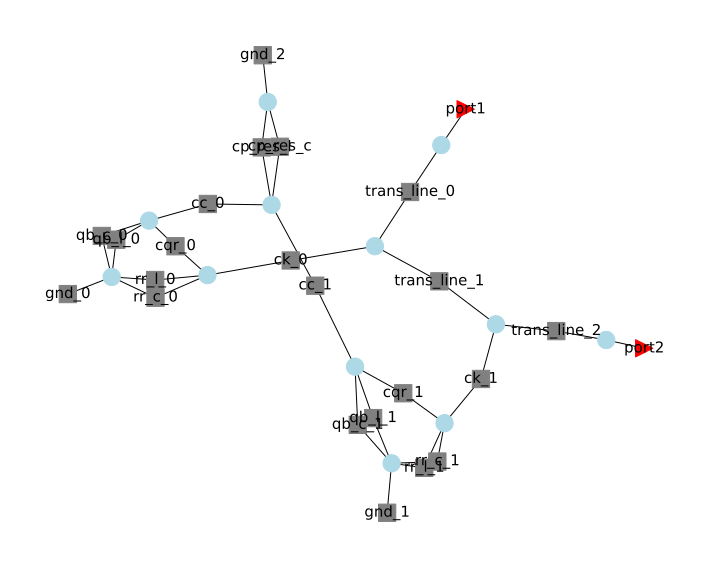

In [18]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

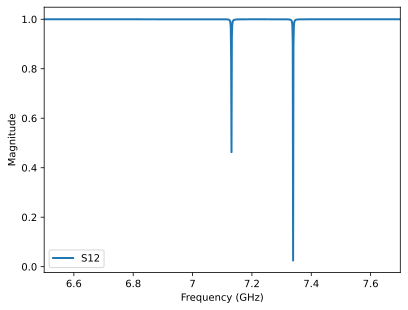

In [19]:
ntw.plot_s_mag(m=0, n=1, lw=2)

### Purcell limit and driveline coupling
Q extracted from Im(Y)/Re(Y)

https://arxiv.org/pdf/2101.09532

https://doi.org/10.1063/1.5089550

https://arxiv.org/abs/2106.06173

In [20]:
# Q_dl_q1 = 1.5e6

P_in = -66 # on-driveline power
V0 = 10**(P_in/20) * np.sqrt(Z0/1000)

omega_q1 = qubit_freq_target[0]*2*np.pi

c_dl_q1 = 0.01 * 1e-15 # To be extracted with Ansys
Gamma_q1 = Z0*(c_dl_q1*omega_q1)**2 / c_sigma
Omega_q1 = V0*c_dl_q1/c_sigma * np.sqrt(planck_h/4/np.pi / Z0) / planck_h
pi_pulse_time_q1 = (1 / (Omega_q1/2/np.pi) )/ 4
T1_purcell_q1 = 1/Gamma_q1 * 1e6
print(f"driveline-qubit capacitance: {c_dl_q1/1e-15:.4f} fF")
print(f"pi-pulse duration: {pi_pulse_time_q1*1e9:.2f} ns")
print(f"T1 purcell from driveline qb1: {T1_purcell_q1} us")

driveline-qubit capacitance: 0.0100 fF
pi-pulse duration: 81.39 ns
T1 purcell from driveline qb1: 17914.54741114372 us


In [21]:
# Q_dl_q2 = 6118963.2619058965
P_in = -66 # on-driveline power
V0 = 10**(P_in/20) * np.sqrt(Z0/1000)

w_q2 = qubit_freq_target[1]*2*np.pi
omega_q1 = qubit_freq_target[1]*2*np.pi

c_dl_q2 = 0.01e-15 # To be extracted with Ansys
Gamma_q2 = Z0*(c_dl_q1*omega_q1)**2 / c_sigma

Omega_q2 = V0*c_dl_q2/c_sigma * np.sqrt(planck_h/4/np.pi / Z0) / planck_h
pi_pulse_time_q2 = (1 / (Omega_q2/2/np.pi) )/ 4
T1_purcell_q2 = 1/Gamma_q2 * 1e6

print(f"driveline-qubit capacitance: {c_dl_q2/1e-15:.4f} fF")
print(f"pi-pulse duration: {pi_pulse_time_q2*1e9:.2f} ns")
print(f"T1 purcell from driveline qb2: {T1_purcell_q2} us")

driveline-qubit capacitance: 0.0100 fF
pi-pulse duration: 81.39 ns
T1 purcell from driveline qb2: 22116.72519894286 us


In [22]:
# Readout resonator Purcell
delta = (rr_freq_target - qubit_freq_target)*2*np.pi
gamma_hz = kappa_target * (expected_g1 / delta)**2 * 2*np.pi
T1_purcell_rr = 1/gamma_hz
print(T1_purcell_rr)
print(f"T1 purcell from readout resonator qb1: {T1_purcell_rr[0]*1e6} us")
print(f"T1 purcell from readout resonator qb2: {T1_purcell_rr[1]*1e6} us")

[0.00018661 0.00023618]
T1 purcell from readout resonator qb1: 186.60784731561463 us
T1 purcell from readout resonator qb2: 236.17555675882483 us


### scikit-rf model for T1
We can compute T1 Purcell by replacing qubits with ports and calculating the admittance. This will also account for T1 Purcell through the coupler.

1-Port Network: '',  4.0-5.5 GHz, 201 pts, z0=[50.+0.j]


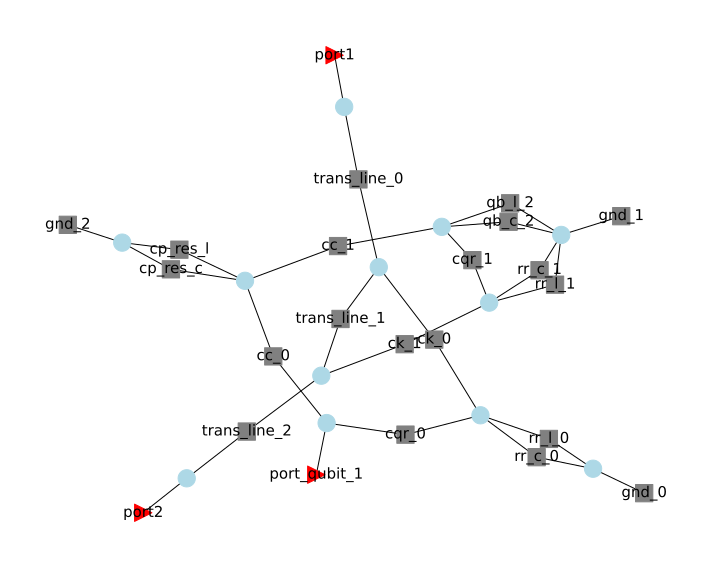

In [23]:
options = {
    "qubit_c": np.array([c_sigma]*2) - np.array([c_r1, c_r2]) - np.array([c_c1, c_c2]) ,
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_r_mode,
    "readout_resonator_l": l_r_mode,
    "ck": cks,
    "substrate_thickness": 550e-6,
    "cqr": np.array([c_r1, c_r2]),
    "cc": np.array([c_c1, c_c2]),
    "qubit_to_estimate": 0,
    "coupler_res_c": (c_cr - c_c1 - c_c2)*1e-10,
    "coupler_res_l": l_cr*1e-10,
    "feedline_traits": transmission_line_tee_points,
    "ep_r": ep_r,
    "a": a,
    "b": b,
    "frequency": [4, 5.5],
    "n_points": 201,
    "type": "T1_Purcell_estimation_coupled_qubits"
}
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

In [24]:
freq_span_q1 = np.linspace(options["frequency"][0], options["frequency"][1], options["n_points"])
qb_idx = np.argmin(abs(freq_span_q1 - qubit_freq_target[0]/1e9))
Y_real_s1 = ntw.y[qb_idx, 0, 0].real
T1_s1_readout_purcell_limit = c_sigma/Y_real_s1
print(f"T1_s1_readout_purcell_limit: {T1_s1_readout_purcell_limit*1e6} us")

T1_s1_readout_purcell_limit: 684.6966248907019 us


In [25]:
J = g_coupling_target**2*(tmon1.E01() + tmon2.E01() - 2*cplr_freq_target) / (2*(tmon1.E01() - cplr_freq_target) * (tmon2.E01() - cplr_freq_target))
print(f"Exchange rate J: {J/1e6:.4f} MHz / 2pi")

Exchange rate J: -4.7756 MHz / 2pi


In [26]:
g1_c = jaynes_cummings_g(EC, Ej1, c_c1, c_cr, cplr_freq_target)
g2_c = jaynes_cummings_g(EC, Ej2, c_c2, c_cr, cplr_freq_target)

In [27]:
df = pd.DataFrame(index=['qb0','qb1'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = np.array(qubit_freq_target) / 1e9
df['anharmonicity [MHz]'] = np.floor(np.array(anharm1, anharm2) / 1e6)
df['chi/2pi [MHz]'] = np.array(chi)/1e6
df['g/2pi [MHz] (to coupler)'] = np.array([g_coupling_target]*2) * 1e-6
df['g/2pi [MHz] (to readout)'] = np.array([g_r1, g_r2]) * 1e-6
df['C_sigma [fF]'] = np.array([c_sigma]*2) * 1e15
df["Lj [nH]"] = np.array([Lj1, Lj2]) * 1e9
df['Ic [nA]'] = np.array([Ic1, Ic2])  * 1e9
df['T1 Purcell through driveline [us]'] = np.floor(np.array([T1_purcell_q1, T1_purcell_q2]))
# df['T1 Purcell through couplers [us]'] = np.floor(np.array([T1_purcell_q1, T1_purcell_q2]))
df['T1 Purcell through readout [us]'] = np.floor(np.array(T1_purcell_rr) * 1e6)
df['Resonator Q'] = np.array([6000, 5900])
df

,resonator 01 [GHz],qubit 01 [GHz],anharmonicity [MHz],chi/2pi [MHz],g/2pi [MHz] (to coupler),g/2pi [MHz] (to readout),C_sigma [fF],Lj [nH],Ic [nA],T1 Purcell through driveline [us],T1 Purcell through readout [us],Resonator Q
qb0,7.4,5.0,-239.0,0.25,90.0,70.090048,90.0,9.498399,34.648575,17914.0,186.0,6000
qb1,7.2,4.5,-239.0,0.25,90.0,78.235937,90.0,11.523334,28.559961,22116.0,236.0,5900
